In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/CVHomework4'

/content/gdrive/MyDrive/CVHomework4


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    # implementing data augmentation
    if augment: 
      data_after_augment = [cv2.flip(img, 1) for img in data]
      data.extend(data_after_augment)
      labels.extend(labels)
    
    # implementing data normalization
    if zero_centered:
      for iterr in range(len(data)):
        mean, standard = cv2.meanStdDev(data[iterr])
        data[iterr] = (data[iterr] - mean)
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Bedroom', 1: 'Highway', 2: 'Forest', 3: 'Office', 4: 'Mountain', 5: 'InsideCity', 6: 'TallBuilding', 7: 'Suburb', 8: 'Coast', 9: 'Kitchen', 10: 'Street', 11: 'Flower', 12: 'LivingRoom', 13: 'Industrial', 14: 'OpenCountry', 15: 'Store'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

Store


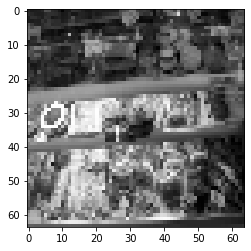

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
The days of hand designed features are gone. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a sample network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))

Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7456 | Average Loss: 2.7456 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.2888 | Average Loss: 2.6304 
Accuracy: 0.348958 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.5959 | Average Loss: 2.4424 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.6999 | Average Loss: 2.2326 
Accuracy: 0.424479 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0972 | Average Loss: 2.1048 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.3424 | Average Loss: 1.9673 
Accuracy: 0.458333 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.8012 | Average Loss: 1.8693 
Epoch: 4 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.0739 | Average Loss: 1.7638 
Accuracy: 0.481771 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.6195 | Average Loss: 1.6848 
Epoch: 5 | Iter:   20 | Time: 00:00:01 | Train Loss: 0.8720 | Average Loss: 1.5979 
Accuracy: 0.4739

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(35 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class Prob1a(nn.Module):
    def __init__(self):
      super(Prob1a,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 1800),
         nn.Linear(1800, 64), 
         nn.Linear(64, 16),
      )
      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      a = self.features(x)  
      a = torch.flatten(a, 1)
      a = self.dropout(a) # new added
      x = self.classifier(a)
      return x  

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = Prob1a() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7711 | Average Loss: 2.7711 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 3.8059 | Average Loss: 5.5975 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3572 | Average Loss: 4.1533 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.1289 | Average Loss: 3.5365 
Accuracy: 0.354167 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.8847 | Average Loss: 3.2626 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.4167 | Average Loss: 2.9991 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.0260 | Average Loss: 2.8069 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.8018 | Average Loss: 2.6530 
Accuracy: 0.403646 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.5365 | Average Loss: 2.5660 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.8580 | Average Loss: 2.4608 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.3493 | Average Loss: 2.3636 
Epoc

**Answer**:

Data augmentation: images are flipped(mirror)

Data normalization: images are zer-centered

Layer 1: 
- Convolution Layer -> 16 channels -> ReLu activation -> Max Pooling

Layer 2:  

- 3 NN Sequential Layers used from 3600,1800,64, to 16 

Layer 3: Dropout = 0.5

...

Accuray on test set:  
- 56.51% on 30th epoch
- Average Loss: 0.8969 

## Problem 1.2

(15 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class Prob1b(nn.Module):
    def __init__(self):
      super(Prob1b,self).__init__()  
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential( # pura new hai yeh
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      self.classifier = nn.Sequential(
         nn.Linear(4608, 64), 
         nn.Linear(64, 16), 
      )
      self.dropout = nn.Dropout(0.5) # drop out value changed
      
    def forward(self, x):
      b = self.layer1(x)
      b = self.layer2(b)  
      b = torch.flatten(b, 1)
      b = self.dropout(b)
      x = self.classifier(b)
      return x  

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = Prob1b() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8016 | Average Loss: 2.8016 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7931 | Average Loss: 3.5229 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.7276 | Average Loss: 3.1296 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.6879 | Average Loss: 2.9870 
Accuracy: 0.085938 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.6423 | Average Loss: 2.9209 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6365 | Average Loss: 2.8634 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.5715 | Average Loss: 2.8174 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.4741 | Average Loss: 2.7758 
Accuracy: 0.203125 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.4436 | Average Loss: 2.7438 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.3502 | Average Loss: 2.7069 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.2938 | Average Loss: 2.6651 
Epoc

**Answer**:

Technique 1: 

Layer 1:

- Convolution Layer -> 64 channels -> ReLu Activation -> Max Pooling


Layer 2:

- Convolution Layer -> 128 channels -> Sigmoid -> Max Pooling


Dense NN:

- 2 NN Sequential Layers used from 4608,64, to 16
- Dropout = 0.5


Accuracy on test set: 

- 66.67% on the 30th epoch
- Average Loss: 1.0329

Accuracy increases/decreases:

- as we can see from our results, accuracy has been increased significantly 

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------  
class Prob1c(nn.Module):
    def __init__(self):
      super(Prob1c,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      
      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024), 
         nn.BatchNorm1d(1024), # new 
         nn.ReLU(), # new
      )
      self.classifier2 = nn.Sequential( # new
         nn.Linear(1024, 16),
      )

      self.dropout = nn.Dropout(0.25)
      
    def forward(self, x):
      c = self.layer1(x)
      c = self.layer2(c)  
      c = torch.flatten(c, 1)
      c = self.dropout(c)
      c = self.classifier1(c)
      x = self.classifier2(c)
      return x  

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = Prob1c() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8047 | Average Loss: 2.8047 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.0076 | Average Loss: 2.4310 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.5269 | Average Loss: 2.1811 
Epoch: 1 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.6221 | Average Loss: 1.9887 
Accuracy: 0.455729 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.1725 | Average Loss: 1.8793 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.0281 | Average Loss: 1.7423 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 0.9138 | Average Loss: 1.6425 
Epoch: 2 | Iter:   60 | Time: 00:00:02 | Train Loss: 1.1006 | Average Loss: 1.5543 
Accuracy: 0.609375 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 0.7733 | Average Loss: 1.4961 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 0.7503 | Average Loss: 1.4296 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 0.6662 | Average Loss: 1.3722 
Epoc

**Answer**:

Technique 2: 

Layer 1:

- Convolution Layer -> 64 channels -> Batch Normalization -> ReLu Activation -> Max Pooling


Layer 2:

- Convolution Layer -> 128 channels -> Sigmoid -> Max Pooling


Classifier 1 & 2:

- 1 NN Sequential Layer1 used from 4608 to 1024
- 1 NN Sequential Layer2 used from 1024 to 16
- Dropout = 0.5


Accuracy on test set: 

- 69.79% on the 12th epoch
- Average Loss: 0.4769 

Accuracy increases/decreases:

- from our results, we can clearly notice that the accuracy has been incresed
- loss has been decreased

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

# i loaded data into size(64,64), trained in samples for a batch size of 64
img_size = (64, 64)
batch_size = 64
# hence loaded the training and testing datasets
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#-------------------------------------------------- 
class Prob1c(nn.Module):
    def __init__(self):
      super(Prob1c,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.Tanh(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      
      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024), 
         nn.BatchNorm1d(1024),
         nn.LeakyReLU(),
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 16),
      )

      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      c = self.layer1(x)
      c = self.layer2(c)  
      c = torch.flatten(c, 1)
      c = self.dropout(c)
      c = self.classifier1(c)
      x = self.classifier2(c)
      return x  

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------

net = Prob1c() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9317 | Average Loss: 2.9317 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.8894 | Average Loss: 2.7769 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.0991 | Average Loss: 2.5551 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.0825 | Average Loss: 2.4232 
Accuracy: 0.346354 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.0091 | Average Loss: 2.3327 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.9343 | Average Loss: 2.2247 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.2785 | Average Loss: 2.1160 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.2175 | Average Loss: 2.0296 
Accuracy: 0.510417 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.3269 | Average Loss: 1.9698 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.3729 | Average Loss: 1.9018 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 0.9619 | Average Loss: 1.8362 
Epoc

**Answer**:

Technique 3: 
Layer 1:

- Convolution Layer -> 64 channels -> Batch Normalization -> Tanh() -> Max Pooling


Layer 2:

- Convolution Layer -> 128 channels -> Sigmoid -> Max Pooling


Classifier 1 & 2:

- 1 NN Sequential Layer1 used from 4608 to 1024
- LeakyReLu activation function used
- 1 NN Sequential Layer2 used from 1024 to 16
- Dropout = 0.5



Accuracy on test set: 
- 70.57% at epoch 28
- Average Loss: 0.4093


Accuracy increases/decreases:

- observing from the results, accuracy has been increased

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(25 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torchvision.models as models
alexnet_network =  models.alexnet(pretrained=True)
print(alexnet_network)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
class Char(nn.Module):
  def __init__(self):
    super(Char,self).__init__()

  def forward(self,x):
    return x

class Prob2a(nn.Module):
    def __init__(self):
      super(Prob2a,self).__init__()  
           
      self.classifier = nn.Sequential(
          nn.Linear(9216, 4096), 
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(4096, 2048),
          nn.Linear(2048, 1024),
          nn.BatchNorm1d(1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024,64),
          nn.Linear(64,16),
      )
      
    def forward(self, x):
      x = self.classifier(x)
      return x  

In [ ]:
alexnet_network.avgpool = Char()
alexnet_network.classifier = Prob2a()
print(alexnet_network)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): Char()
  (classifier): Prob2a(
    (classifier): Sequential(
      (0): Linear(in_features=9216, out_features=4096, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = alexnet_network
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8345 | Average Loss: 2.8345 
Epoch: 1 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.0056 | Average Loss: 1.6941 
Accuracy: 0.718750 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:04 | Train Loss: 0.4391 | Average Loss: 1.2466 
Epoch: 2 | Iter:   20 | Time: 00:00:06 | Train Loss: 0.3504 | Average Loss: 0.9731 
Accuracy: 0.773438 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:08 | Train Loss: 0.1730 | Average Loss: 0.8284 
Epoch: 3 | Iter:   20 | Time: 00:00:10 | Train Loss: 0.1785 | Average Loss: 0.6974 
Accuracy: 0.752604 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:12 | Train Loss: 0.1368 | Average Loss: 0.6173 
Epoch: 4 | Iter:   20 | Time: 00:00:14 | Train Loss: 0.1296 | Average Loss: 0.5513 
Accuracy: 0.752604 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:15 | Train Loss: 0.1029 | Average Loss: 0.5065 
Epoch: 5 | Iter:   20 | Time: 00:00:17 | Train Loss: 0.1031 | Average Loss: 0.4630 
Accuracy: 0.7994

**Answer**:

(1) which layers of AlexNet have been replaced
- all 7 classifiers have been modified and 2 more layed has been added


(2) the architecture of the new layers added including activation methods (same as problem 1)

Features Layers : 

(classifier): Sequential(

- (0): Linear(in_features=9216, out_features=4096, bias=True)

- (1): ReLU()

- (2): Dropout(p=0.25, inplace=False)

- (3): Linear(in_features=4096, out_features=1024, bias=True)
- (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

- (5): ReLU()

- (6): Dropout(p=0.5, inplace=False)      

- (7): Linear(in_features=1024, out_features=16, bias=True)




(3) the final accuracy on test set

Accuracy on test set: 
- 88.5% on 8th epoch
- Average Loss: 0.004



### Problem 2.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(25 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [ ]:
# freezing weights
alexnet_ft = models.alexnet(pretrained=True)
for param in alexnet_ft.parameters():
    param.requires_grad = False

print(alexnet_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
alexnet_ft = torchvision.models.alexnet(pretrained=True)
alexnet_ft.eval()

def extract_features(model, dataset):
  ft, lab = [], []
  for first, second in dataset:
        y0 = second.float()
        ops = model.features(first.float())
        ft.append(ops.detach().cpu().numpy().flatten().reshape(len(first), 256 * 6 * 6))
        lab += list(y0.detach().cpu().numpy())
  lab, ft = np.array(lab), np.vstack(ft)
  return ft, lab

train_feat, train_label = extract_features(alexnet_ft, trainloader_large)
test_feat, test_label = extract_features(alexnet_ft, testloader_large)

In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn import svm 
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(train_feat, train_label)
label_pred_test = svm_model.predict(test_feat)
conc = np.array(label_pred_test)
summ = sum(conc == test_label)
test_accuracy = summ / float(len(test_label))
print(f"Accuracy = {test_accuracy:.6f} ")

Accuracy = 0.843750 


**Answer**:

Accuracy on test set: 83.85%

### Problem 2.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torchvision.models as tvmodel
finetunemodel = tvmodel.resnet50(pretrained=True)
print("\n initially created ResNet : \n")
print(finetunemodel)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 initially created ResNet : 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

**Answer**:

Accuracy on test set:


In [ ]:
finetunemodel.fc = nn.Sequential(
    nn.BatchNorm1d(2048),
    nn.Dropout(0.75),
    nn.Linear(2048,1000),
    nn.ReLU(),
    nn.Linear(1000,16,bias=True))

print("\n updated ResNet model : \n")
print(finetunemodel)


 updated ResNet model : 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 30
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(finetunemodel.parameters(), lr=0.02, momentum=0.5)
trainModel(finetunemodel, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.9654 | Average Loss: 2.9654 
Epoch: 1 | Iter:   20 | Time: 00:00:15 | Train Loss: 0.7716 | Average Loss: 1.6684 
Accuracy: 0.885417 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:28 | Train Loss: 0.3548 | Average Loss: 1.1615 
Epoch: 2 | Iter:   20 | Time: 00:00:43 | Train Loss: 0.1731 | Average Loss: 0.8553 
Accuracy: 0.903646 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:00:56 | Train Loss: 0.0757 | Average Loss: 0.6917 
Epoch: 3 | Iter:   20 | Time: 00:01:11 | Train Loss: 0.0301 | Average Loss: 0.5578 
Accuracy: 0.901042 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:01:24 | Train Loss: 0.0208 | Average Loss: 0.4782 
Epoch: 4 | Iter:   20 | Time: 00:01:39 | Train Loss: 0.0119 | Average Loss: 0.4088 
Accuracy: 0.919271 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:01:52 | Train Loss: 0.0142 | Average Loss: 0.3639 
Epoch: 5 | Iter:   20 | Time: 00:02:07 | Train Loss: 0.0080 | Average Loss: 0.3220 
Accuracy: 0.9244

<!--Write your report here in markdown or html-->
